In [1]:
import requests
#!conda install -c conda-forge wikipedia
from time import sleep
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [2]:

def rowgetDataText(tr, coltag='td'): # td (data) or th (header)
    cols = []
    for td in tr.find_all(coltag):
        cols.append(td.get_text(strip=True))
    return cols

def tableDataText(table):       
    rows = []
    trs = table.find_all('tr')
    headerow = rowgetDataText(trs[0], 'th')
    if headerow: # if there is a header row include first
        rows.append(headerow)
        trs = trs[1:]
    for tr in trs: # for every table row
        rows.append(rowgetDataText(tr, 'td')) # data row
    return rows

table = soup.find('table', {'class': 'wikitable sortable'})
list_table = tableDataText(table)
list_table

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned'],
 ['M8A', 'Not assigned', 'Not assigned'],
 ['M9A', "Queen's Park", "Queen's Park"],
 ['M1B', 'Scarborough', 'Rouge'],
 ['M1B', 'Scarborough', 'Malvern'],
 ['M2B', 'Not assigned', 'Not assigned'],
 ['M3B', 'North York', 'Don Mills North'],
 ['M4B', 'East York', 'Woodbine Gardens'],
 ['M4B', 'East York', 'Parkview Hill'],
 ['M5B', 'Downtown Toronto', 'Ryerson'],
 ['M5B', 'Downtown Toronto', 'Garden District'],
 ['M6B', 'North York', 'Glencairn'],
 ['M7B', 'Not assigned', 'Not assigned'],
 ['M8B', 'Not assigned', 'Not assigned'],
 ['M9B', 'Etobicoke', 'Cloverdale'],
 ['M9B', 'Etobicoke', 'Islington'],
 ['M9B', 'Et

In [95]:
import pandas as pd

dftable = pd.DataFrame(list_table[1:], columns=list_table[0])
dftable.head(4)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village


Drop not assigned borough

In [96]:
dftable = dftable[dftable.Borough != 'Not assigned']
dftable.shape

(210, 3)

  Merege multiple rows into one

In [107]:
#df = dftable.groupby(['Postcode'])['Neighbourhood'].apply(' ,'.join).reset_index()
df = dftable.groupby(['Postcode', 'Borough'])['Neighbourhood'].agg(' ,'.join).reset_index()
df.head(4)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge ,Malvern"
1,M1C,Scarborough,"Highland Creek ,Rouge Hill ,Port Union"
2,M1E,Scarborough,"Guildwood ,Morningside ,West Hill"
3,M1G,Scarborough,Woburn


Replace Not assigned in Neighbourhood

In [108]:
df.loc[df['Neighbourhood'] == 'Not assigned', 'Neighbourhood'] = df['Borough']
df.head(4)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge ,Malvern"
1,M1C,Scarborough,"Highland Creek ,Rouge Hill ,Port Union"
2,M1E,Scarborough,"Guildwood ,Morningside ,West Hill"
3,M1G,Scarborough,Woburn


Check dimension

In [7]:
df.shape

(103, 3)

In [8]:
#df_can = pd.read_csv('C:/Users/xzhang/Downloads/Geospatial_Coordinates.csv')#, index_col = 0)
df_can = pd.read_csv('http://cocl.us/Geospatial_data')#, index_col = 0)

merge two datasets

In [9]:
dfm = df.merge(df_can, left_on='Postcode', right_on='Postal Code').drop(columns = 'Postal Code')
dfm.head(4)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge ,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek ,Rouge Hill ,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood ,Morningside ,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917


get the location

In [10]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [14]:
# create map of New York using latitude and longitude values
#!conda install -c conda-forge folium=0.5.0
neighborhoods = dfm
import folium # map rendering library
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
#map_toronto

Get data using foursqaure API

In [15]:
CLIENT_ID = 'BMWVCTTW5K0L51TMQEHKDRS0ZLHCVOJEIXIW4FOUZUMPSNXP' # your Foursquare ID
CLIENT_SECRET = '2XTUVEL1DCZKVLXC0CCGT40WWQ3FNXPTKXRGBXOFSZYNPC2K' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BMWVCTTW5K0L51TMQEHKDRS0ZLHCVOJEIXIW4FOUZUMPSNXP
CLIENT_SECRET:2XTUVEL1DCZKVLXC0CCGT40WWQ3FNXPTKXRGBXOFSZYNPC2K


In [16]:
dfm.loc[0, 'Neighbourhood']
neighborhood_latitude = dfm.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dfm.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = dfm.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))



Latitude and longitude values of Rouge ,Malvern are 43.806686299999996, -79.19435340000001.


In [17]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=BMWVCTTW5K0L51TMQEHKDRS0ZLHCVOJEIXIW4FOUZUMPSNXP&client_secret=2XTUVEL1DCZKVLXC0CCGT40WWQ3FNXPTKXRGBXOFSZYNPC2K&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=500&limit=100'

In [18]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dcf74f85fb726001b330ae8'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.8111863045, 'lng': -79.18812958073042},
   'sw': {'lat': 43.80218629549999, 'lng': -79.2005772192696}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': "Wendy's",
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'display'

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Wendy's,Fast Food Restaurant,43.807448,-79.199056


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
dfm_venues = getNearbyVenues(names=dfm['Neighbourhood'],
                                   latitudes=dfm['Latitude'],
                                   longitudes=dfm['Longitude']
                                  )



Rouge ,Malvern
Highland Creek ,Rouge Hill ,Port Union
Guildwood ,Morningside ,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park ,Ionview ,Kennedy Park
Clairlea ,Golden Mile ,Oakridge
Cliffcrest ,Cliffside ,Scarborough Village West
Birch Cliff ,Cliffside West
Dorset Park ,Scarborough Town Centre ,Wexford Heights
Maryvale ,Wexford
Agincourt
Clarks Corners ,Sullivan ,Tam O'Shanter
Agincourt North ,L'Amoreaux East ,Milliken ,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview ,Henry Farm ,Oriole
Bayview Village
Silver Hills ,York Mills
Newtonbrook ,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park ,Don Mills South
Bathurst Manor ,Downsview North ,Wilson Heights
Northwood Park ,York University
CFB Toronto ,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens ,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West ,

In [23]:
print(dfm_venues.shape)
dfm_venues.head()

(2250, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge ,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek ,Rouge Hill ,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood ,Morningside ,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood ,Morningside ,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood ,Morningside ,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


Clean venues data and prepare for analysis

In [25]:
dfn = dfm_venues.groupby('Neighborhood').count().sort_values('Venue Category',ascending = False)#.tail(20)#head(20)
dfn
#dfn
#print('There are {} uniques categories.'.format(len(dfm_venues['Venue Category'].unique())))

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide ,King ,Richmond",100,100,100,100,100,100
St. James Town,100,100,100,100,100,100
"Ryerson ,Garden District",100,100,100,100,100,100
"Harbourfront East ,Toronto Islands ,Union Station",100,100,100,100,100,100
"First Canadian Place ,Underground city",100,100,100,100,100,100
"Design Exchange ,Toronto Dominion Centre",100,100,100,100,100,100
"Commerce Court ,Victoria Hotel",100,100,100,100,100,100
Stn A PO Boxes 25 The Esplanade,99,99,99,99,99,99
"Chinatown ,Grange Park ,Kensington Market",97,97,97,97,97,97


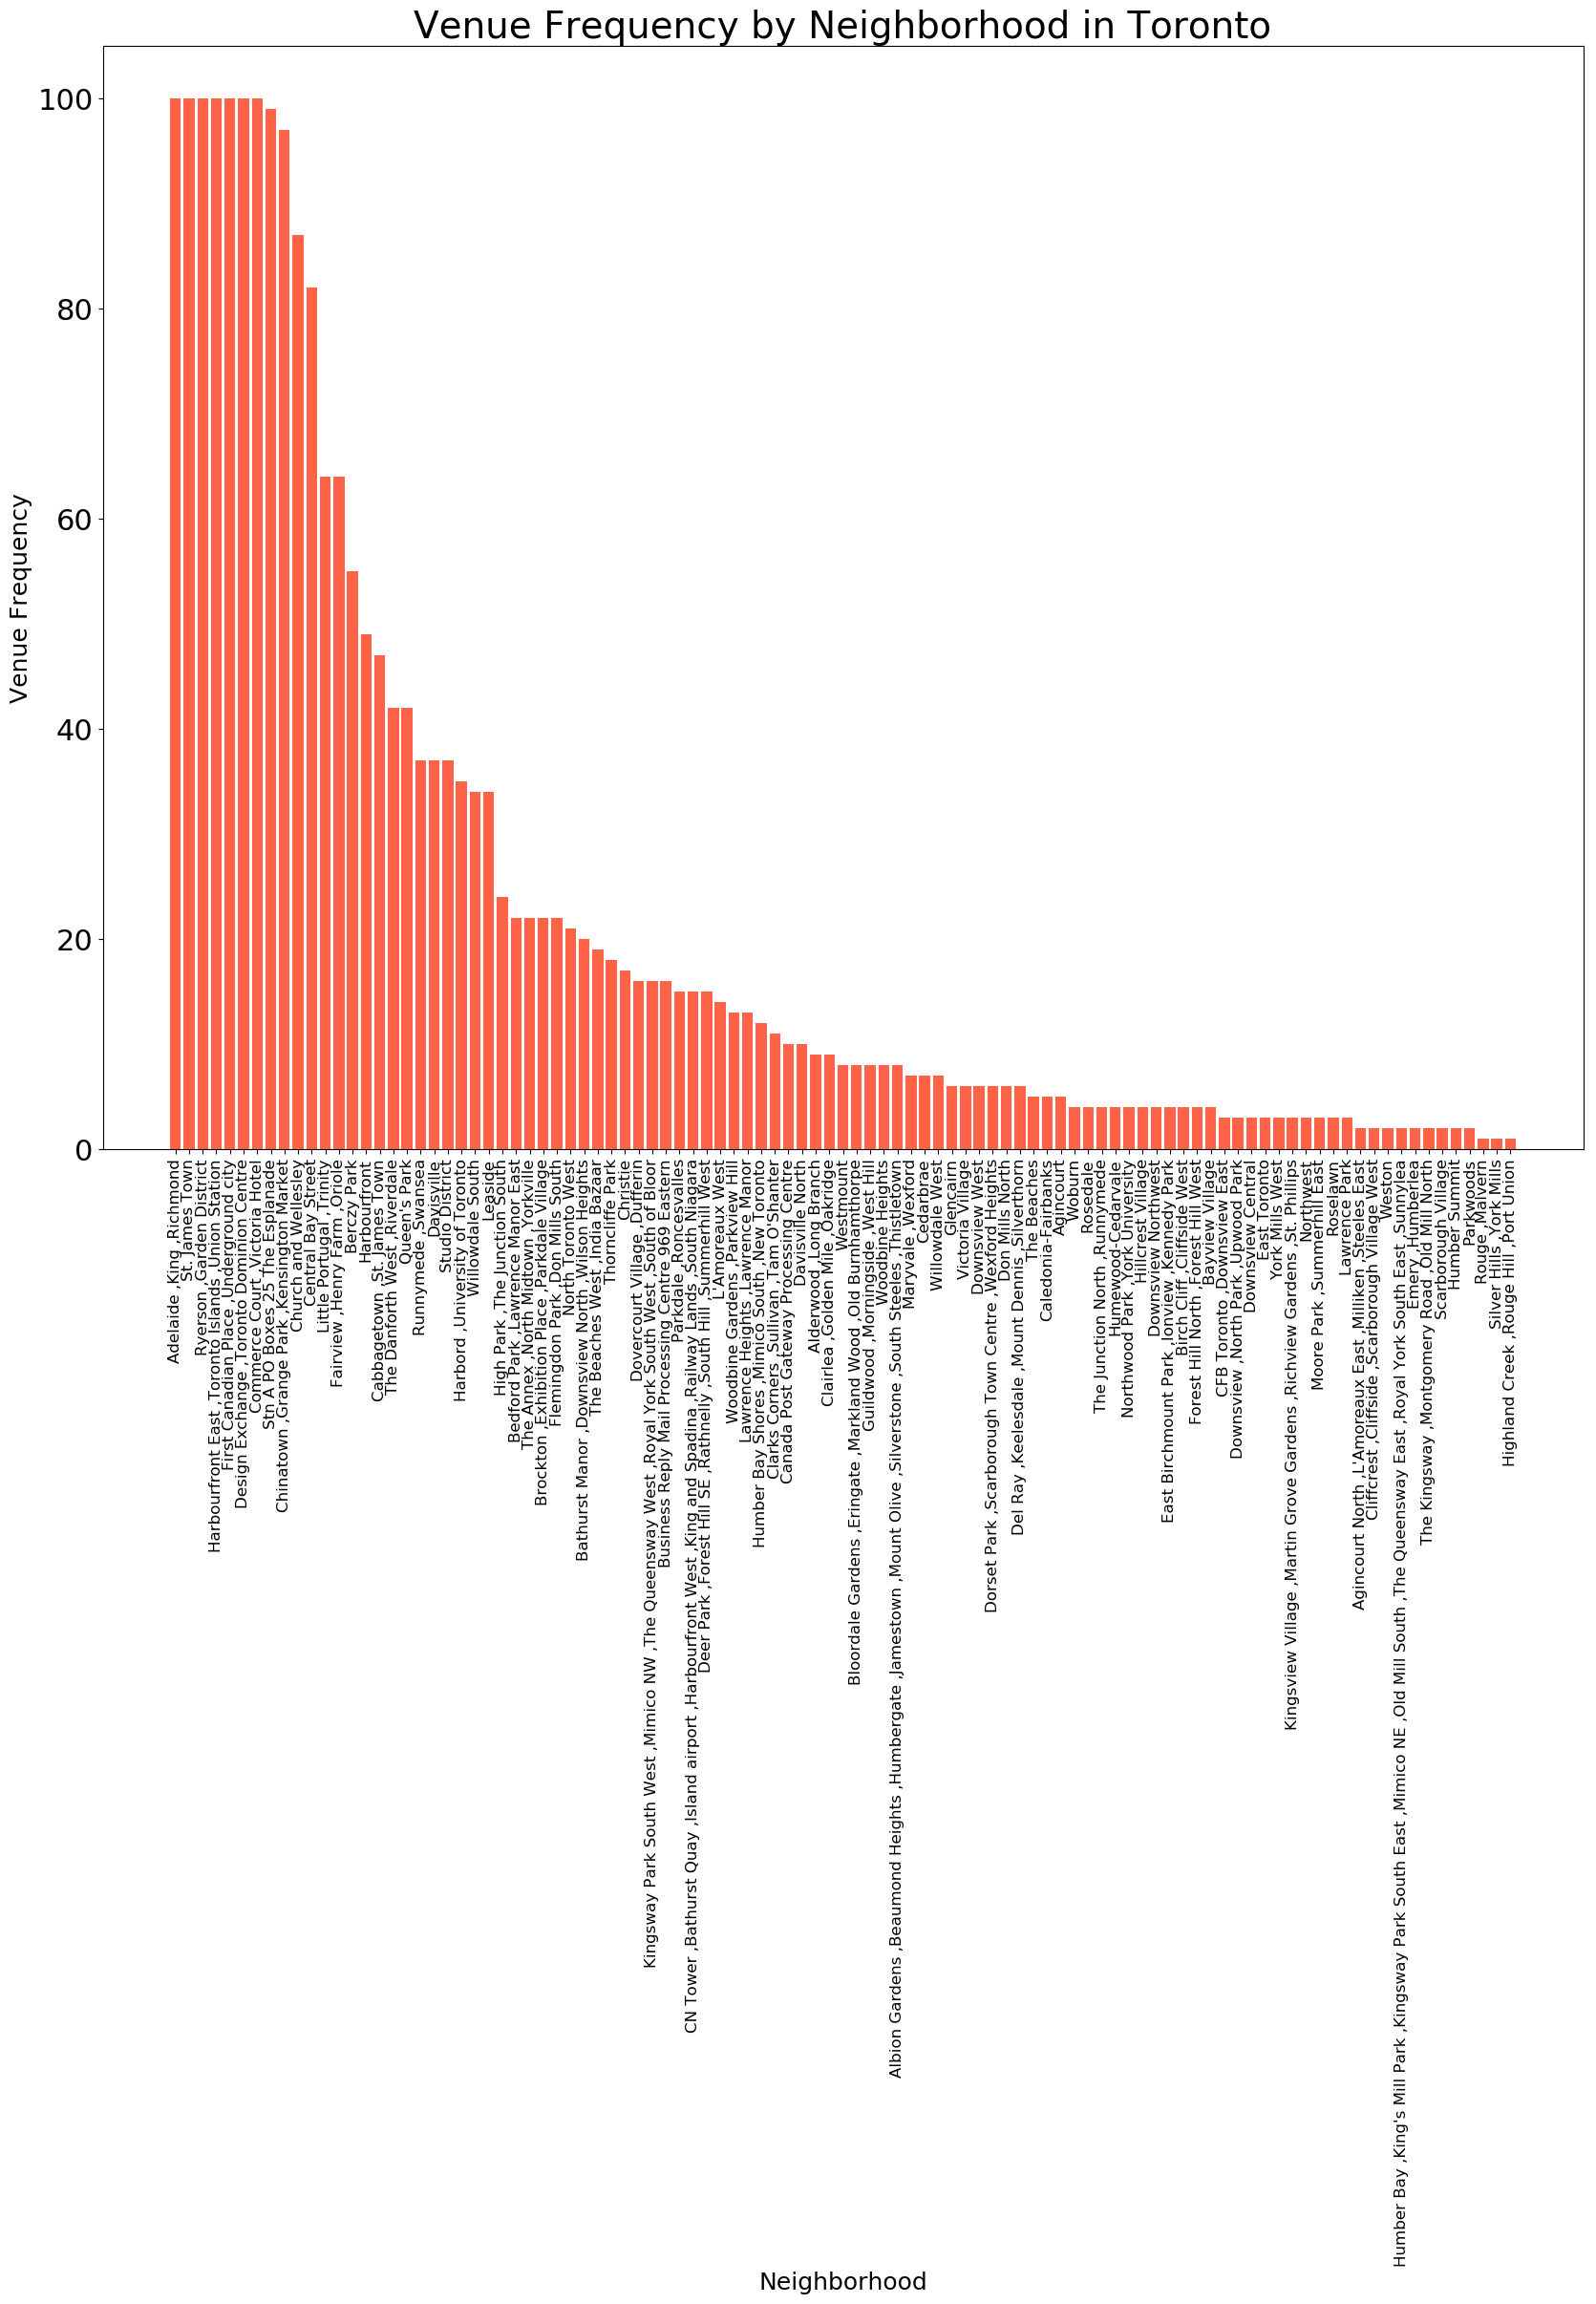

In [58]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (20,15))
plt.bar(dfn.index, dfn['Venue Category'], color = 'tomato')
plt.title("Venue Frequency by Neighborhood in Toronto", fontsize = '28')
plt.xlabel('Neighborhood', fontsize = '18')
plt.ylabel('Venue Frequency', fontsize = '18')
plt.xticks(fontsize='12', rotation ='90')
plt.yticks(fontsize='22')
#plt.savefig('pdtor.jpg')
plt.show()

In [28]:
# one hot encoding
dfm_onehot = pd.get_dummies(dfm_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dfm_onehot['Neighborhood'] = dfm_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfm_onehot.columns[-1]] + list(dfm_onehot.columns[:-1])
dfm_onehot = dfm_onehot[fixed_columns]

dfm_onehot.head()

dfm_onehot.shape

(2250, 266)

In [29]:
dfm_grouped = dfm_onehot.groupby('Neighborhood').mean().reset_index()
dfm_grouped.shape


(99, 266)

In [30]:
num_top_venues = 5

for hood in dfm_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = dfm_grouped[dfm_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide ,King ,Richmond----
                 venue  freq
0          Coffee Shop  0.07
1                 Café  0.05
2                  Bar  0.04
3           Steakhouse  0.04
4  American Restaurant  0.03


----Agincourt----
                       venue  freq
0                     Lounge   0.2
1               Skating Rink   0.2
2  Latin American Restaurant   0.2
3             Breakfast Spot   0.2
4             Clothing Store   0.2


----Agincourt North ,L'Amoreaux East ,Milliken ,Steeles East----
                             venue  freq
0                       Playground   0.5
1                             Park   0.5
2         Mediterranean Restaurant   0.0
3  Molecular Gastronomy Restaurant   0.0
4       Modern European Restaurant   0.0


----Albion Gardens ,Beaumond Heights ,Humbergate ,Jamestown ,Mount Olive ,Silverstone ,South Steeles ,Thistletown----
            venue  freq
0     Pizza Place  0.12
1     Video Store  0.12
2        Pharmacy  0.12
3      Beer Store  0.12
4  Sandwic

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
import numpy as np # library to handle data in a vectorized manner
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dfm_grouped['Neighborhood']

for ind in np.arange(dfm_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dfm_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide ,King ,Richmond",Coffee Shop,Café,Bar,Steakhouse,Breakfast Spot,Thai Restaurant,Restaurant,Bakery,Hotel,Sushi Restaurant
1,Agincourt,Latin American Restaurant,Lounge,Breakfast Spot,Clothing Store,Skating Rink,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dessert Shop,Empanada Restaurant
2,"Agincourt North ,L'Amoreaux East ,Milliken ,St...",Playground,Park,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop
3,"Albion Gardens ,Beaumond Heights ,Humbergate ,...",Pharmacy,Grocery Store,Pizza Place,Fried Chicken Joint,Video Store,Beer Store,Sandwich Place,Fast Food Restaurant,Discount Store,Dessert Shop
4,"Alderwood ,Long Branch",Pizza Place,Gym,Skating Rink,Dance Studio,Coffee Shop,Pub,Sandwich Place,Pharmacy,Airport Service,Deli / Bodega


In [33]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [46]:
dfm_grouped_clustering = dfm_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(2,100)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(dfm_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (98) found smaller than n_clusters (99). Possibly due to duplicate points in X.
  return_n_iter=True)


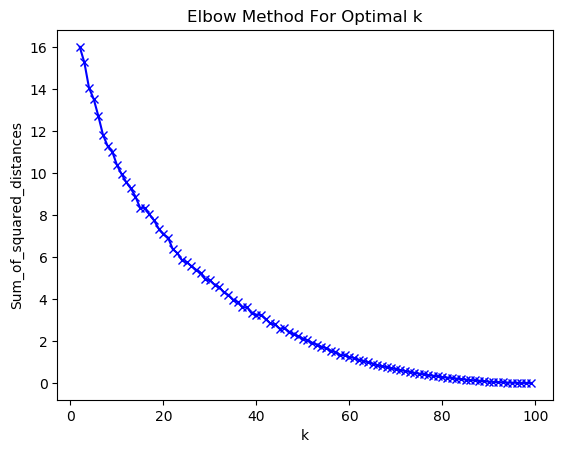

In [47]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [50]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(dfm_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(dfm_grouped_clustering, labels, metric = 'euclidean'))

sil

[0.23933553942305444,
 0.246137109082824,
 0.2705366309921475,
 0.2592030460747208,
 0.27025140374356,
 0.25614219761541307,
 0.26881055973847795,
 0.03266622128818739,
 0.026240329592822624]

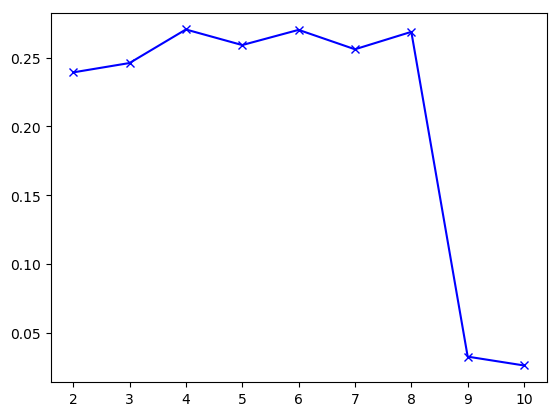

In [52]:
K = range(2,kmax+1)
plt.plot(K, sil, 'bx-')
#plt.xlabel('k')
#plt.ylabel('Sum_of_squared_distances')
#plt.title('Elbow Method For Optimal k')
plt.show()

In [53]:
# set number of clusters
kclusters = 8

dfm_grouped_clustering = dfm_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
len(kmeans.labels_)#[0:10] 
kmeans.labels_


array([0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 4, 0, 0,
       0, 3, 3, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0, 0,
       3, 0, 0, 0, 0, 1, 0, 3, 0, 7, 0, 0, 3, 2, 0, 0, 0, 0, 3, 0, 0, 0,
       6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], dtype=int32)

In [54]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,"Adelaide ,King ,Richmond",Coffee Shop,Café,Bar,Steakhouse,Breakfast Spot,Thai Restaurant,Restaurant,Bakery,Hotel,Sushi Restaurant
1,0,Agincourt,Latin American Restaurant,Lounge,Breakfast Spot,Clothing Store,Skating Rink,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dessert Shop,Empanada Restaurant
2,3,"Agincourt North ,L'Amoreaux East ,Milliken ,St...",Playground,Park,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop
3,0,"Albion Gardens ,Beaumond Heights ,Humbergate ,...",Pharmacy,Grocery Store,Pizza Place,Fried Chicken Joint,Video Store,Beer Store,Sandwich Place,Fast Food Restaurant,Discount Store,Dessert Shop
4,0,"Alderwood ,Long Branch",Pizza Place,Gym,Skating Rink,Dance Studio,Coffee Shop,Pub,Sandwich Place,Pharmacy,Airport Service,Deli / Bodega
5,0,"Bathurst Manor ,Downsview North ,Wilson Heights",Coffee Shop,Sushi Restaurant,Pharmacy,Pizza Place,Chinese Restaurant,Middle Eastern Restaurant,Restaurant,Deli / Bodega,Sandwich Place,Bridal Shop
6,0,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Women's Store,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop
7,0,"Bedford Park ,Lawrence Manor East",Italian Restaurant,Coffee Shop,Pub,Pizza Place,Butcher,Sushi Restaurant,Café,Indian Restaurant,Fast Food Restaurant,Sandwich Place
8,0,Berczy Park,Coffee Shop,Bakery,Steakhouse,Beer Bar,Cocktail Bar,Cheese Shop,Farmers Market,Café,Seafood Restaurant,Clothing Store
9,0,"Birch Cliff ,Cliffside West",Skating Rink,College Stadium,Café,General Entertainment,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant


In [103]:
manhattan_merged = dfm

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

manhattan_merged#.head() # check the last columns!
new = manhattan_merged.dropna()
new.dtypes
#
new['Cluster Labels'] = new['Cluster Labels'].astype(int)
new

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge ,Malvern",43.806686,-79.194353,7,Fast Food Restaurant,Women's Store,Deli / Bodega,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
1,M1C,Scarborough,"Highland Creek ,Rouge Hill ,Port Union",43.784535,-79.160497,5,Bar,Women's Store,Department Store,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
2,M1E,Scarborough,"Guildwood ,Morningside ,West Hill",43.763573,-79.188711,0,Mexican Restaurant,Spa,Pizza Place,Electronics Store,Rental Car Location,Breakfast Spot,Medical Center,Intersection,Diner,Dessert Shop
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Pharmacy,Korean Restaurant,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Fried Chicken Joint,Bakery,Hakka Restaurant,Athletics & Sports,Bank,Thai Restaurant,Caribbean Restaurant,Women's Store,Discount Store,Dim Sum Restaurant
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,3,Playground,Cosmetics Shop,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
6,M1K,Scarborough,"East Birchmount Park ,Ionview ,Kennedy Park",43.727929,-79.262029,0,Coffee Shop,Discount Store,Department Store,Convenience Store,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Dog Run,Doner Restaurant
7,M1L,Scarborough,"Clairlea ,Golden Mile ,Oakridge",43.711112,-79.284577,0,Bakery,Bus Line,Park,Bus Station,Fast Food Restaurant,Intersection,Soccer Field,Construction & Landscaping,Comfort Food Restaurant,Empanada Restaurant
8,M1M,Scarborough,"Cliffcrest ,Cliffside ,Scarborough Village West",43.716316,-79.239476,0,Motel,American Restaurant,Women's Store,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
9,M1N,Scarborough,"Birch Cliff ,Cliffside West",43.692657,-79.264848,0,Skating Rink,College Stadium,Café,General Entertainment,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant


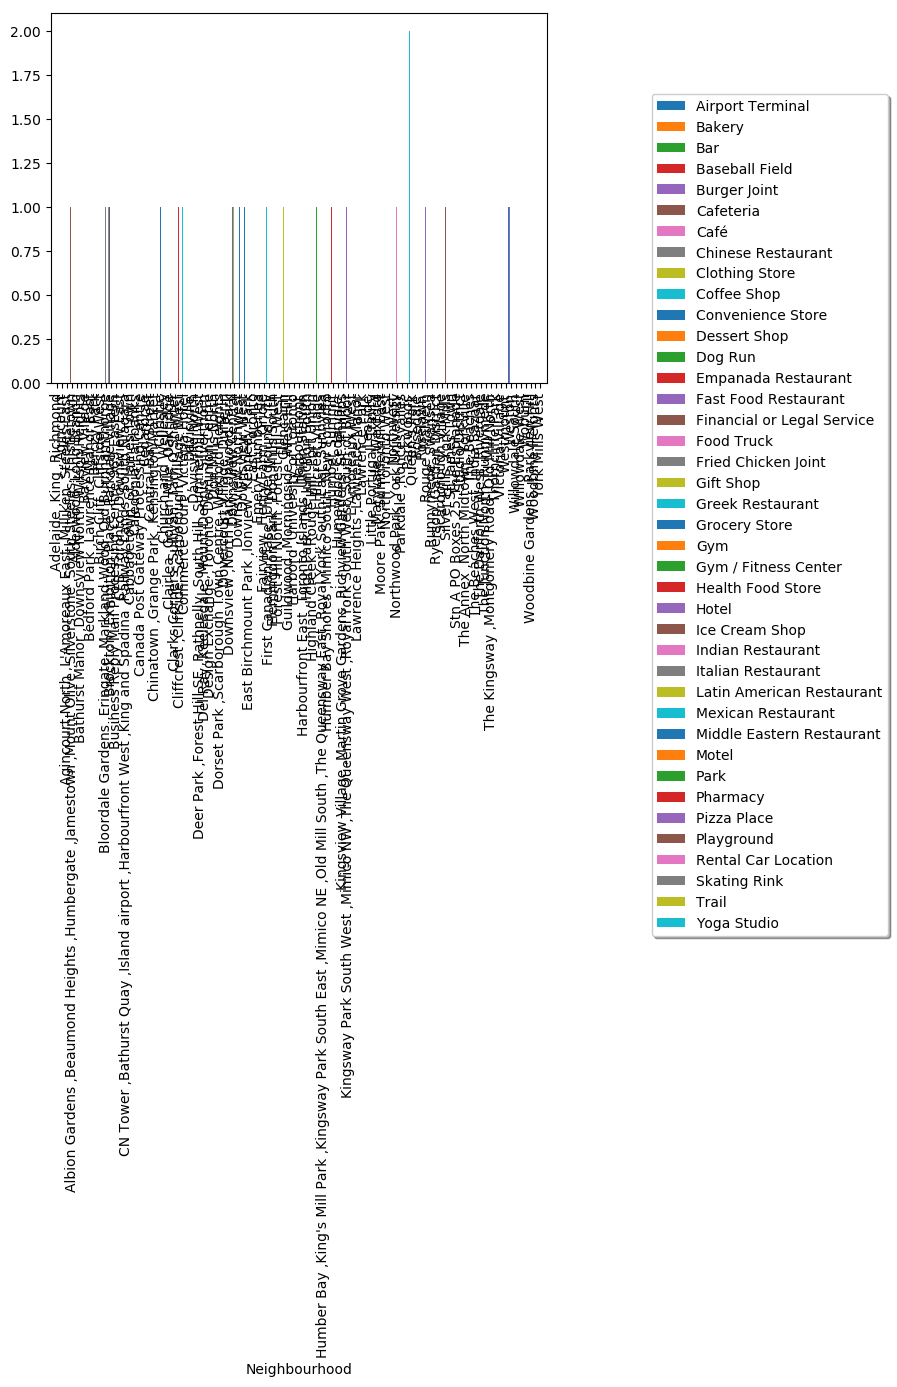

In [104]:
#df = new['Cluster Labels', 'Neighbourhood', '1st Most Common Venue'].groupby('Cluster Labels').count()
df = pd.crosstab(new['Cluster Labels'],  
                            new['Neighbourhood'],
                                margins = False) 
df2 = pd.crosstab(new['Cluster Labels'],  
                            new['1st Most Common Venue'],
                                margins = False) 

df3 = pd.crosstab(new['Neighbourhood'],  
                            new['1st Most Common Venue'],
                                margins = False) 

df3

ax = df3.plot.bar(stacked=False, width = 2)
#plt.legend(title='mark')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.show()

In [61]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


In [62]:

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


In [63]:

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new['Latitude'], new['Longitude'], new['Neighbourhood'], new['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Clustering check

In [64]:
new.loc[new['Cluster Labels'] == 0, new.columns[[1] + list(range(5, new.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,0,Mexican Restaurant,Spa,Pizza Place,Electronics Store,Rental Car Location,Breakfast Spot,Medical Center,Intersection,Diner,Dessert Shop
3,Scarborough,0,Coffee Shop,Pharmacy,Korean Restaurant,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore
4,Scarborough,0,Fried Chicken Joint,Bakery,Hakka Restaurant,Athletics & Sports,Bank,Thai Restaurant,Caribbean Restaurant,Women's Store,Discount Store,Dim Sum Restaurant
6,Scarborough,0,Coffee Shop,Discount Store,Department Store,Convenience Store,Women's Store,Donut Shop,Dim Sum Restaurant,Diner,Dog Run,Doner Restaurant
7,Scarborough,0,Bakery,Bus Line,Park,Bus Station,Fast Food Restaurant,Intersection,Soccer Field,Construction & Landscaping,Comfort Food Restaurant,Empanada Restaurant
8,Scarborough,0,Motel,American Restaurant,Women's Store,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
9,Scarborough,0,Skating Rink,College Stadium,Café,General Entertainment,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
10,Scarborough,0,Indian Restaurant,Pet Store,Vietnamese Restaurant,Furniture / Home Store,Chinese Restaurant,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner
11,Scarborough,0,Middle Eastern Restaurant,Auto Garage,Bakery,Breakfast Spot,Sandwich Place,Shopping Mall,Dog Run,Dim Sum Restaurant,Diner,Discount Store
12,Scarborough,0,Latin American Restaurant,Lounge,Breakfast Spot,Clothing Store,Skating Rink,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dessert Shop,Empanada Restaurant


In [ ]:
new.loc[new['Cluster Labels'] == 1, new.columns[[1] + list(range(5, new.shape[1]))]]

In [ ]:
new.loc[new['Cluster Labels'] == 2, new.columns[[1] + list(range(5, new.shape[1]))]]

In [ ]:
new.loc[new['Cluster Labels'] == 3, new.columns[[1] + list(range(5, new.shape[1]))]]

In [ ]:
new.loc[new['Cluster Labels'] == 4, new.columns[[1] + list(range(5, new.shape[1]))]]

In [88]:
#!conda install -c conda-forge wikipedia
import wikipedia as wp
import pandas as pd

html2 = wp.page("Demographics of Toronto neighbourhoods").html().encode("UTF-8")
dft1 = pd.read_html(html2)[1]
dft1 = pd.DataFrame(dft1)

dft1#.head()

#html3 = wp.page("Demographics_of_Toronto").html().encode("UTF-8")
#dft2 = pd.read_html(html3)[7]
#dft2 = pd.DataFrame(dft2)

#dft2.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN
5,Amesbury,NY,"0280.00, 0281.01, 0281.02",17318,3.51,4934,1.1,27546,16.4,19.7,Spanish (6.1%),06.1% Spanish,NaN
6,Armour Heights,NY,0298.00,4384,2.29,1914,2.0,116651,10.8,16.1,Russian (9.4%),09.4% Russian,NaN
7,Banbury,NY,0267.00,6641,2.72,2442,5.0,92319,6.1,4.8,Unspecified Chinese (5.1%),05.1% Unspecified Chinese,NaN
8,Bathurst Manor,NY,"0297.01, 0310.01, 0310.02",14945,4.69,3187,12.3,34169,13.4,18.6,Russian (9.5%),09.5% Russian,NaN
9,Bay Street Corridor,OCoT,0062.01,4787,0.11,43518,3.0,40598,17.1,49.3,Mandarin (9.6%),09.6% Mandarin,NaN


In [118]:
dftm = pd.merge(dft1, df, left_on='Name', right_on='Neighbourhood', how = 'right')#.drop(columns = 'Postal Code')
dftm#.dropna('Neighbourhood')


,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map,Postcode,Borough,Neighbourhood
0,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577.0,12.45,3580.0,4.6,25750.0,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN,M1S,Scarborough,Agincourt
1,Bayview Village,NY,"0305.01, 305.02",12280.0,4.14,2966.0,41.6,46752.0,14.4,15.6,Cantonese (8.4%),08.4% Cantonese,NaN,M2K,North York,Bayview Village
2,Church and Wellesley,OCoT,"0063.01, 0063.02",13397.0,0.55,24358.0,8.8,37653.0,25.1,57.0,Spanish (1.8%),01.8% Spanish,NaN,M4Y,Downtown Toronto,Church and Wellesley
3,Davisville,OCoT,"0126.00, 0127.00, 0128.02, 0128.03, 0128.04",23727.0,3.14,7556.0,4.5,55735.0,26.0,31.7,Persian (1.5%),01.5% Persian,NaN,M4S,Central Toronto,Davisville
4,Humber Summit,NY,"0315.01, 0315.02, 0315.03",12766.0,7.89,1618.0,2.1,26117.0,7.3,7.6,Italian (15.1%),15.1% Italian,NaN,M9L,North York,Humber Summit
5,Lawrence Park,OCoT,"0138.00, 0265.00",6653.0,3.64,1828.0,-5.1,214110.0,8.3,4.6,French (0.8%),00.8% French,NaN,M4N,Central Toronto,Lawrence Park
6,Leaside,EY,"0195.00, 0196.00",13876.0,2.81,4938.0,3.0,82670.0,9.7,10.5,Bulgarian (0.4%),00.4% Bulgarian,NaN,M4G,East York,Leaside
7,Parkwoods,NY,"0270.01, 0270.02, 0271.01, 0271.02, 0272.01, 0...",26533.0,4.96,5349.0,-3.7,34811.0,14.0,22.5,Unspecified Chinese (3.4%),03.4% Unspecified Chinese,NaN,M3A,North York,Parkwoods
8,Rosedale,OCoT,"0086.00, 0087.00",7672.0,2.72,2821.0,4.8,213941.0,11.3,11.9,Unspecified Chinese (1.0%),01.0% Unspecified Chinese,NaN,M4W,Downtown Toronto,Rosedale
9,Scarborough Village,S,"0331.03, 0332.00",12796.0,2.03,6303.0,-9.0,24413.0,16.2,22.0,Tamil (11.4%),11.4% Tamil,NaN,M1J,Scarborough,Scarborough Village


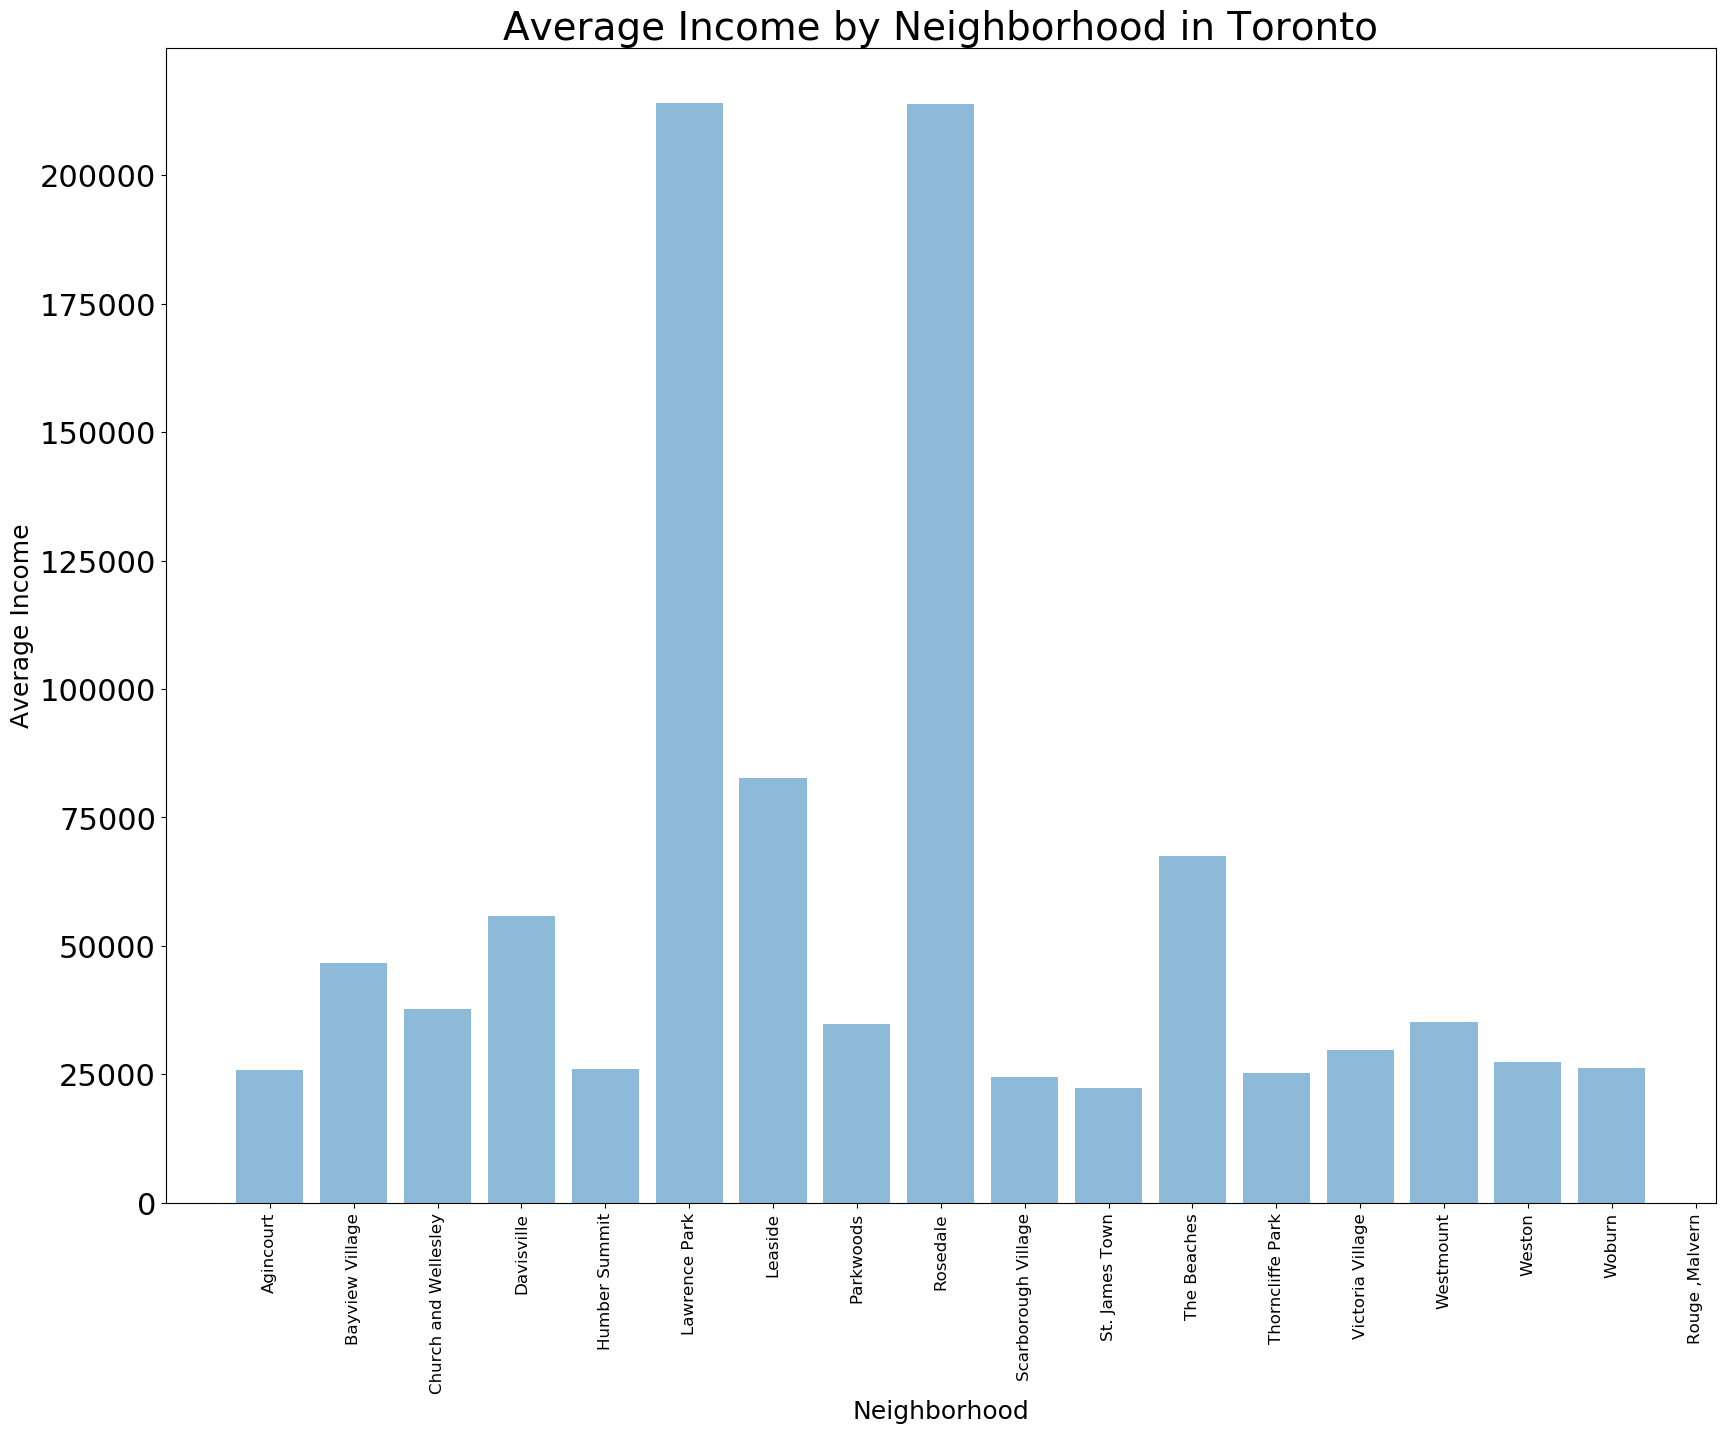

In [119]:

plt.figure(figsize = (20,15))
plt.bar(dftm['Neighbourhood'], dftm['Average Income'], align='center', alpha=0.5)
plt.title("Average Income by Neighborhood in Toronto", fontsize = '28')
plt.xlabel('Neighborhood', fontsize = '18')
plt.ylabel('Average Income', fontsize = '18')
plt.xticks(fontsize='12', rotation ='90')
plt.yticks(fontsize='22')
#plt.savefig('pdtor.jpg')
plt.show()

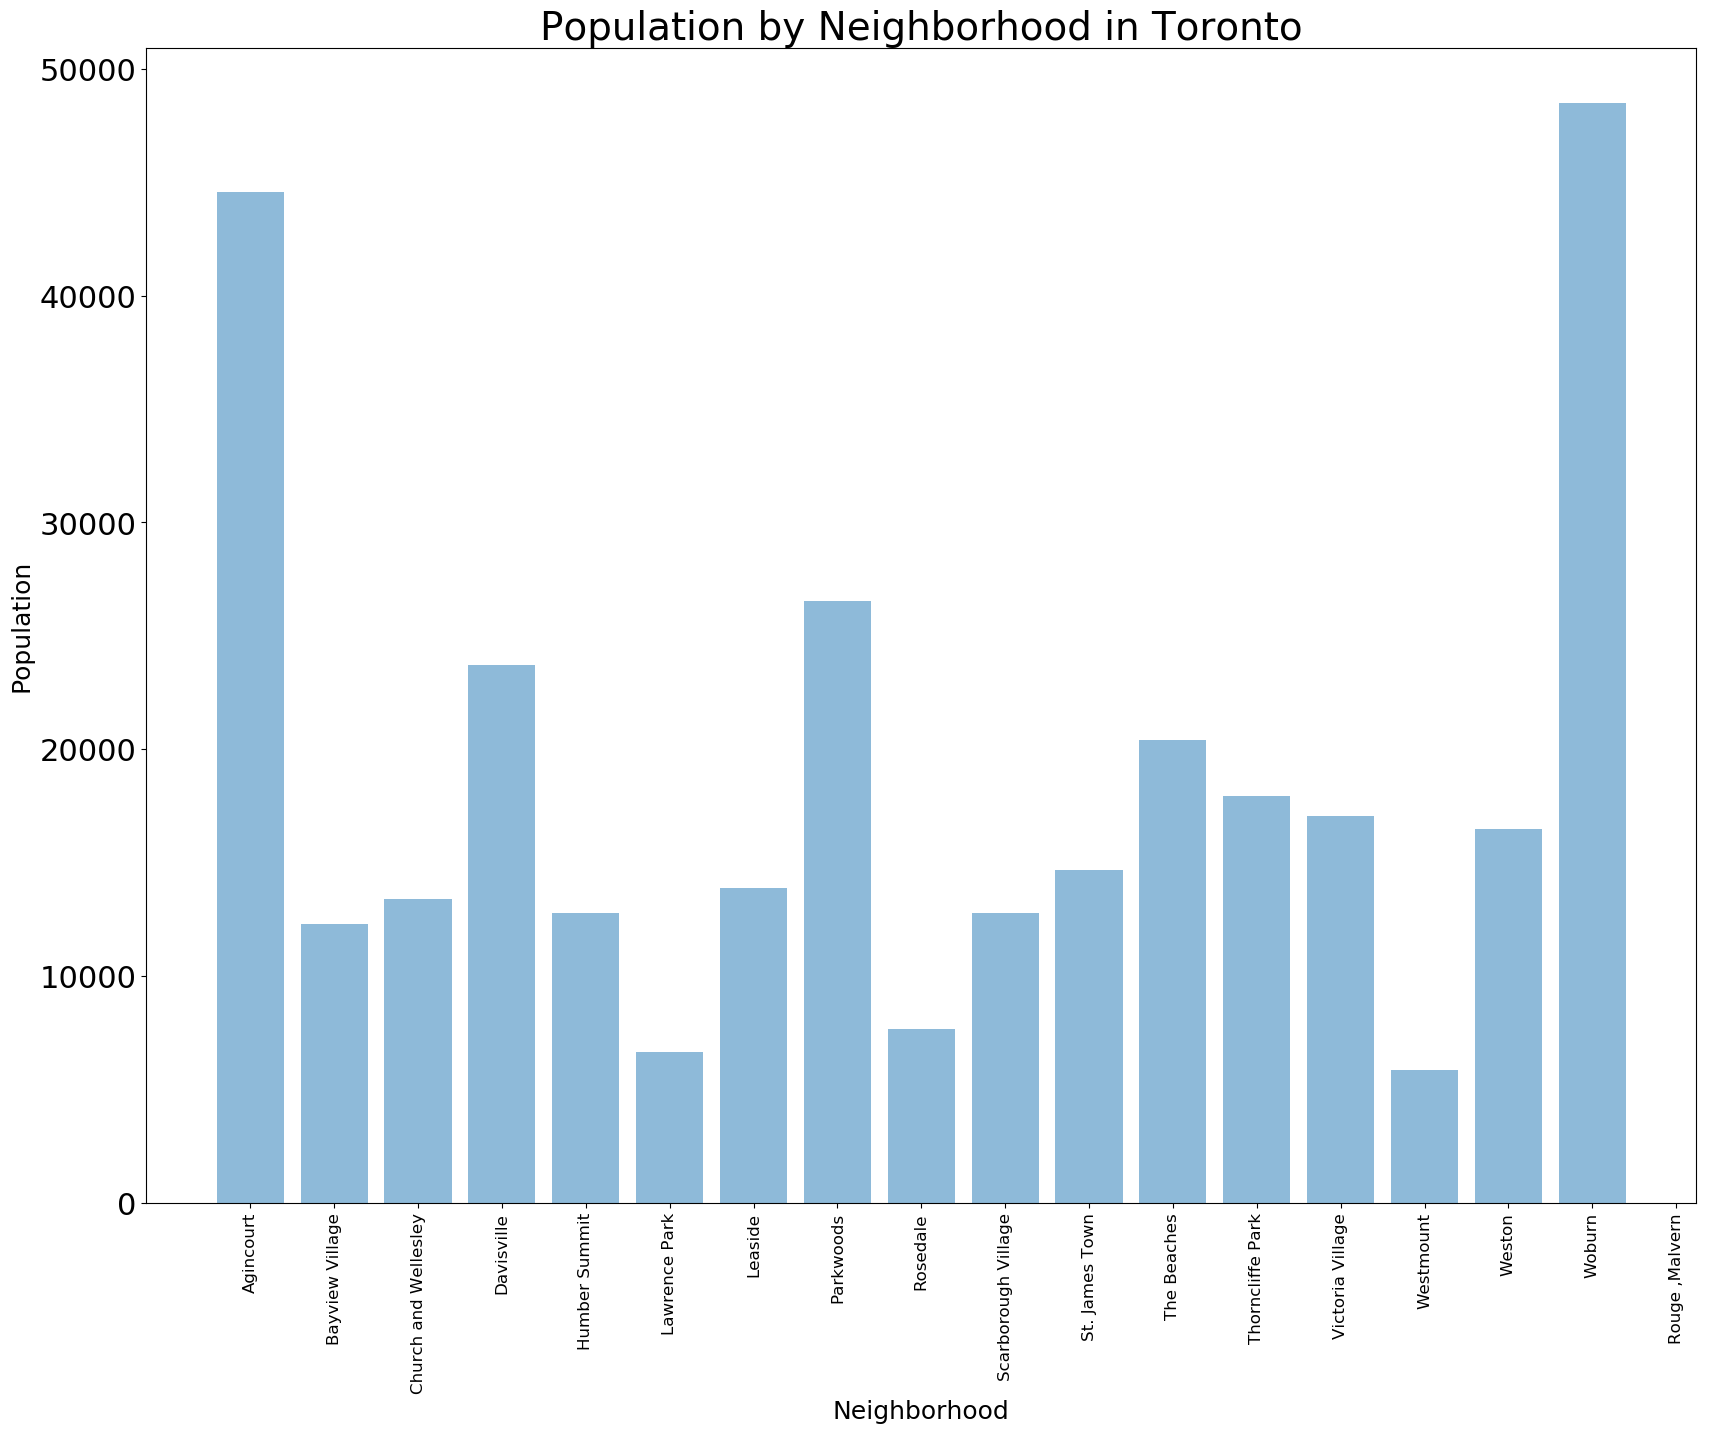

In [121]:
plt.figure(figsize = (20,15))
plt.bar(dftm['Neighbourhood'], dftm['Population'], align='center', alpha=0.5)
plt.title("Population by Neighborhood in Toronto", fontsize = '28')
plt.xlabel('Neighborhood', fontsize = '18')
plt.ylabel('Population', fontsize = '18')
plt.xticks(fontsize='12', rotation ='90')
plt.yticks(fontsize='22')
#plt.savefig('pdtor.jpg')
plt.show()

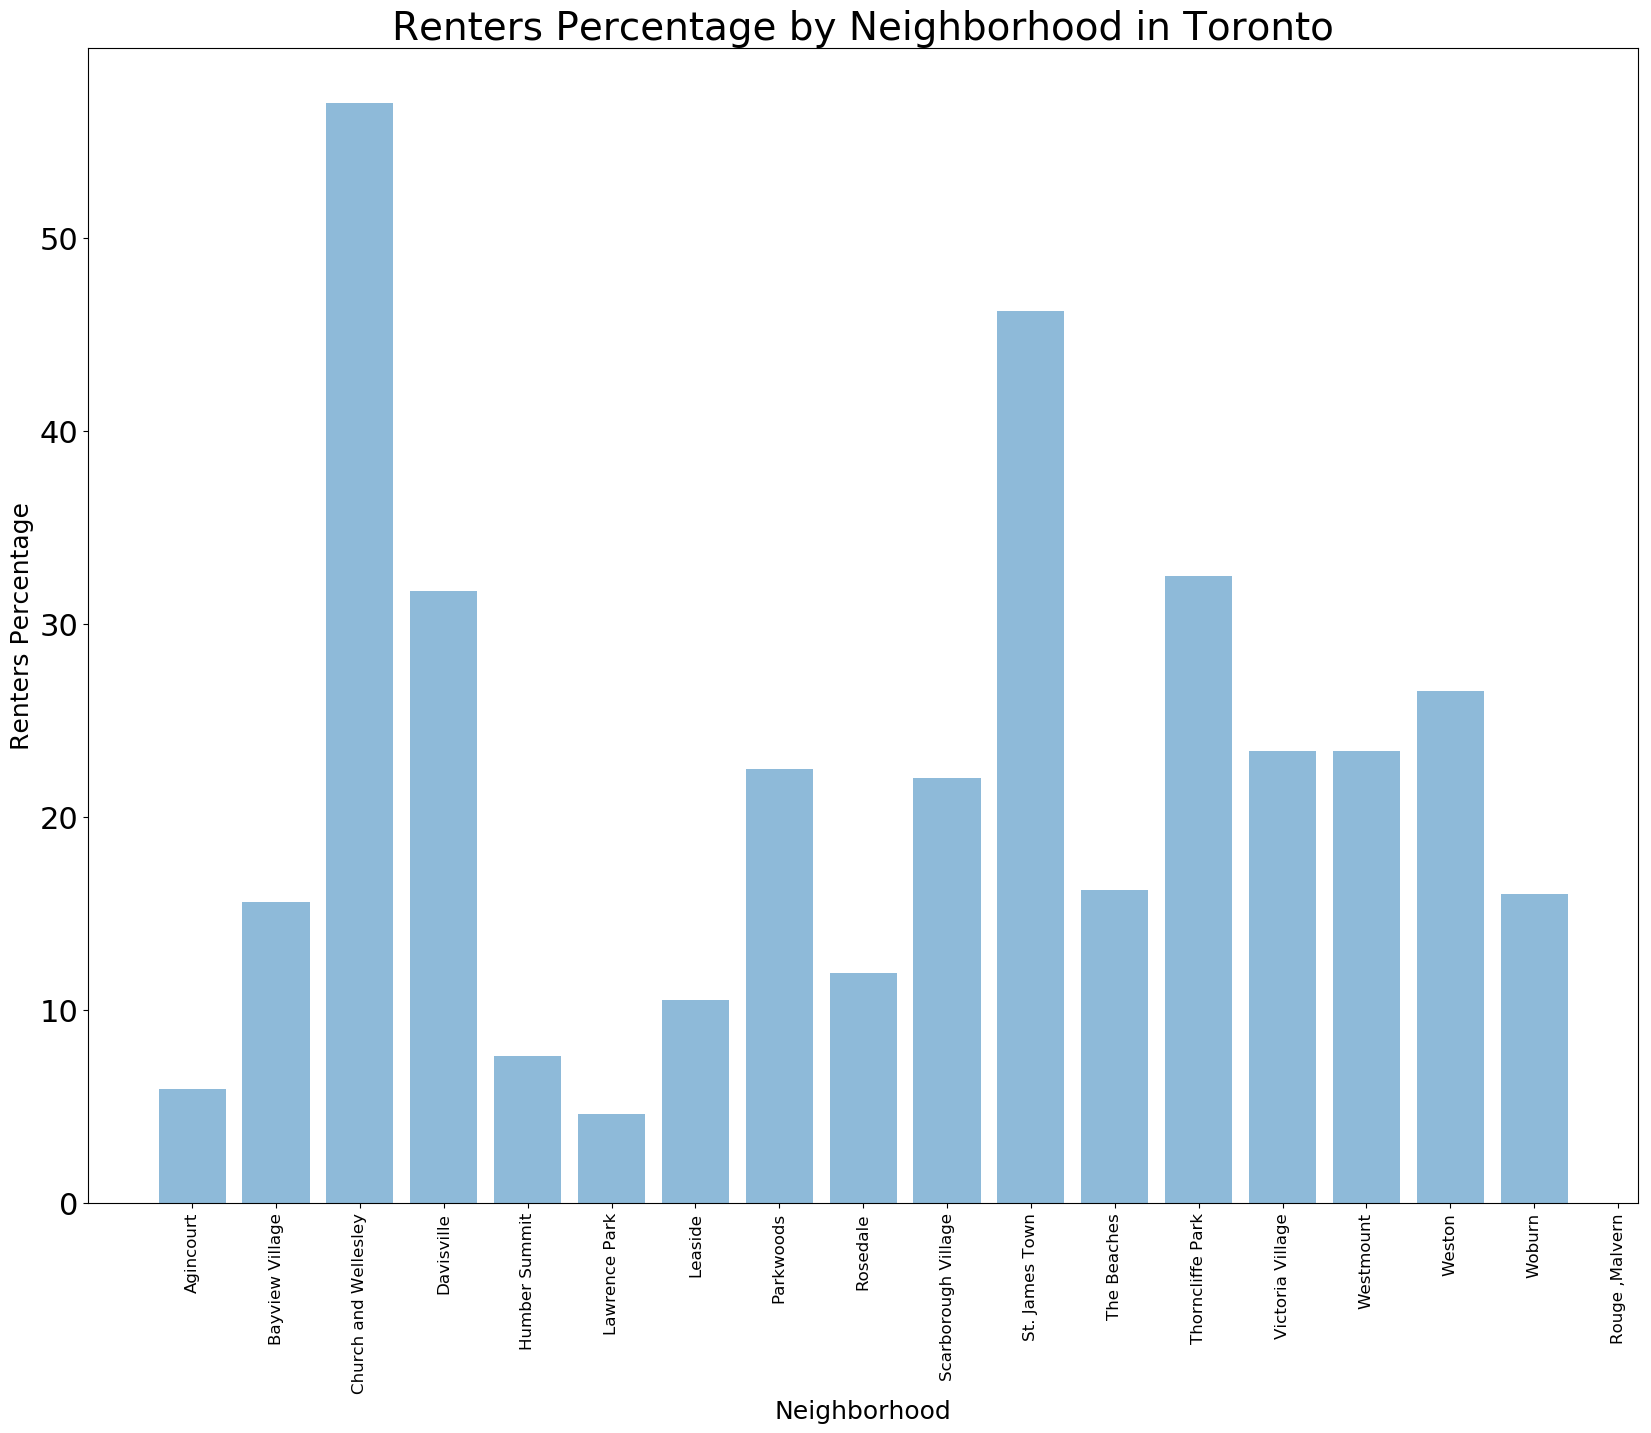

In [123]:
plt.figure(figsize = (20,15))
plt.bar(dftm['Neighbourhood'], dftm['% Renters'], align='center', alpha=0.5)
plt.title("Renters Percentage by Neighborhood in Toronto", fontsize = '28')
plt.xlabel('Neighborhood', fontsize = '18')
plt.ylabel('Renters Percentage', fontsize = '18')
plt.xticks(fontsize='12', rotation ='90')
plt.yticks(fontsize='22')
#plt.savefig('pdtor.jpg')
plt.show()